Build a CNN-LSTM model for Activity Recognition on the UCF-101 dataset. The dataset can
be downloaded from the following link: https://www.crcv.ucf.edu/data/UCF101.php . The model
should be built as follows:
1. Encoder is a CNN. The input image is given to CNN to extract the features. The last hidden
state of the CNN is connected to the Decoder.
2. Decoder is LSTM. The first time step receives the encoded output from the encoder.
3. Add other layers as needed.

**IMPORTING LIBRARIES**

In [1]:
import os
import cv2
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model,to_categorical
from sklearn.model_selection import train_test_split

Setting random seed constant


In [2]:
seed_c=20
np.random.seed(seed_c)
random.seed(seed_c)
tf.random.set_seed(seed_c)

**Importing the dataset**

In [3]:
%%capture
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
!unrar x UCF101.rar

**Visualization the dataset**

Total no of class:101


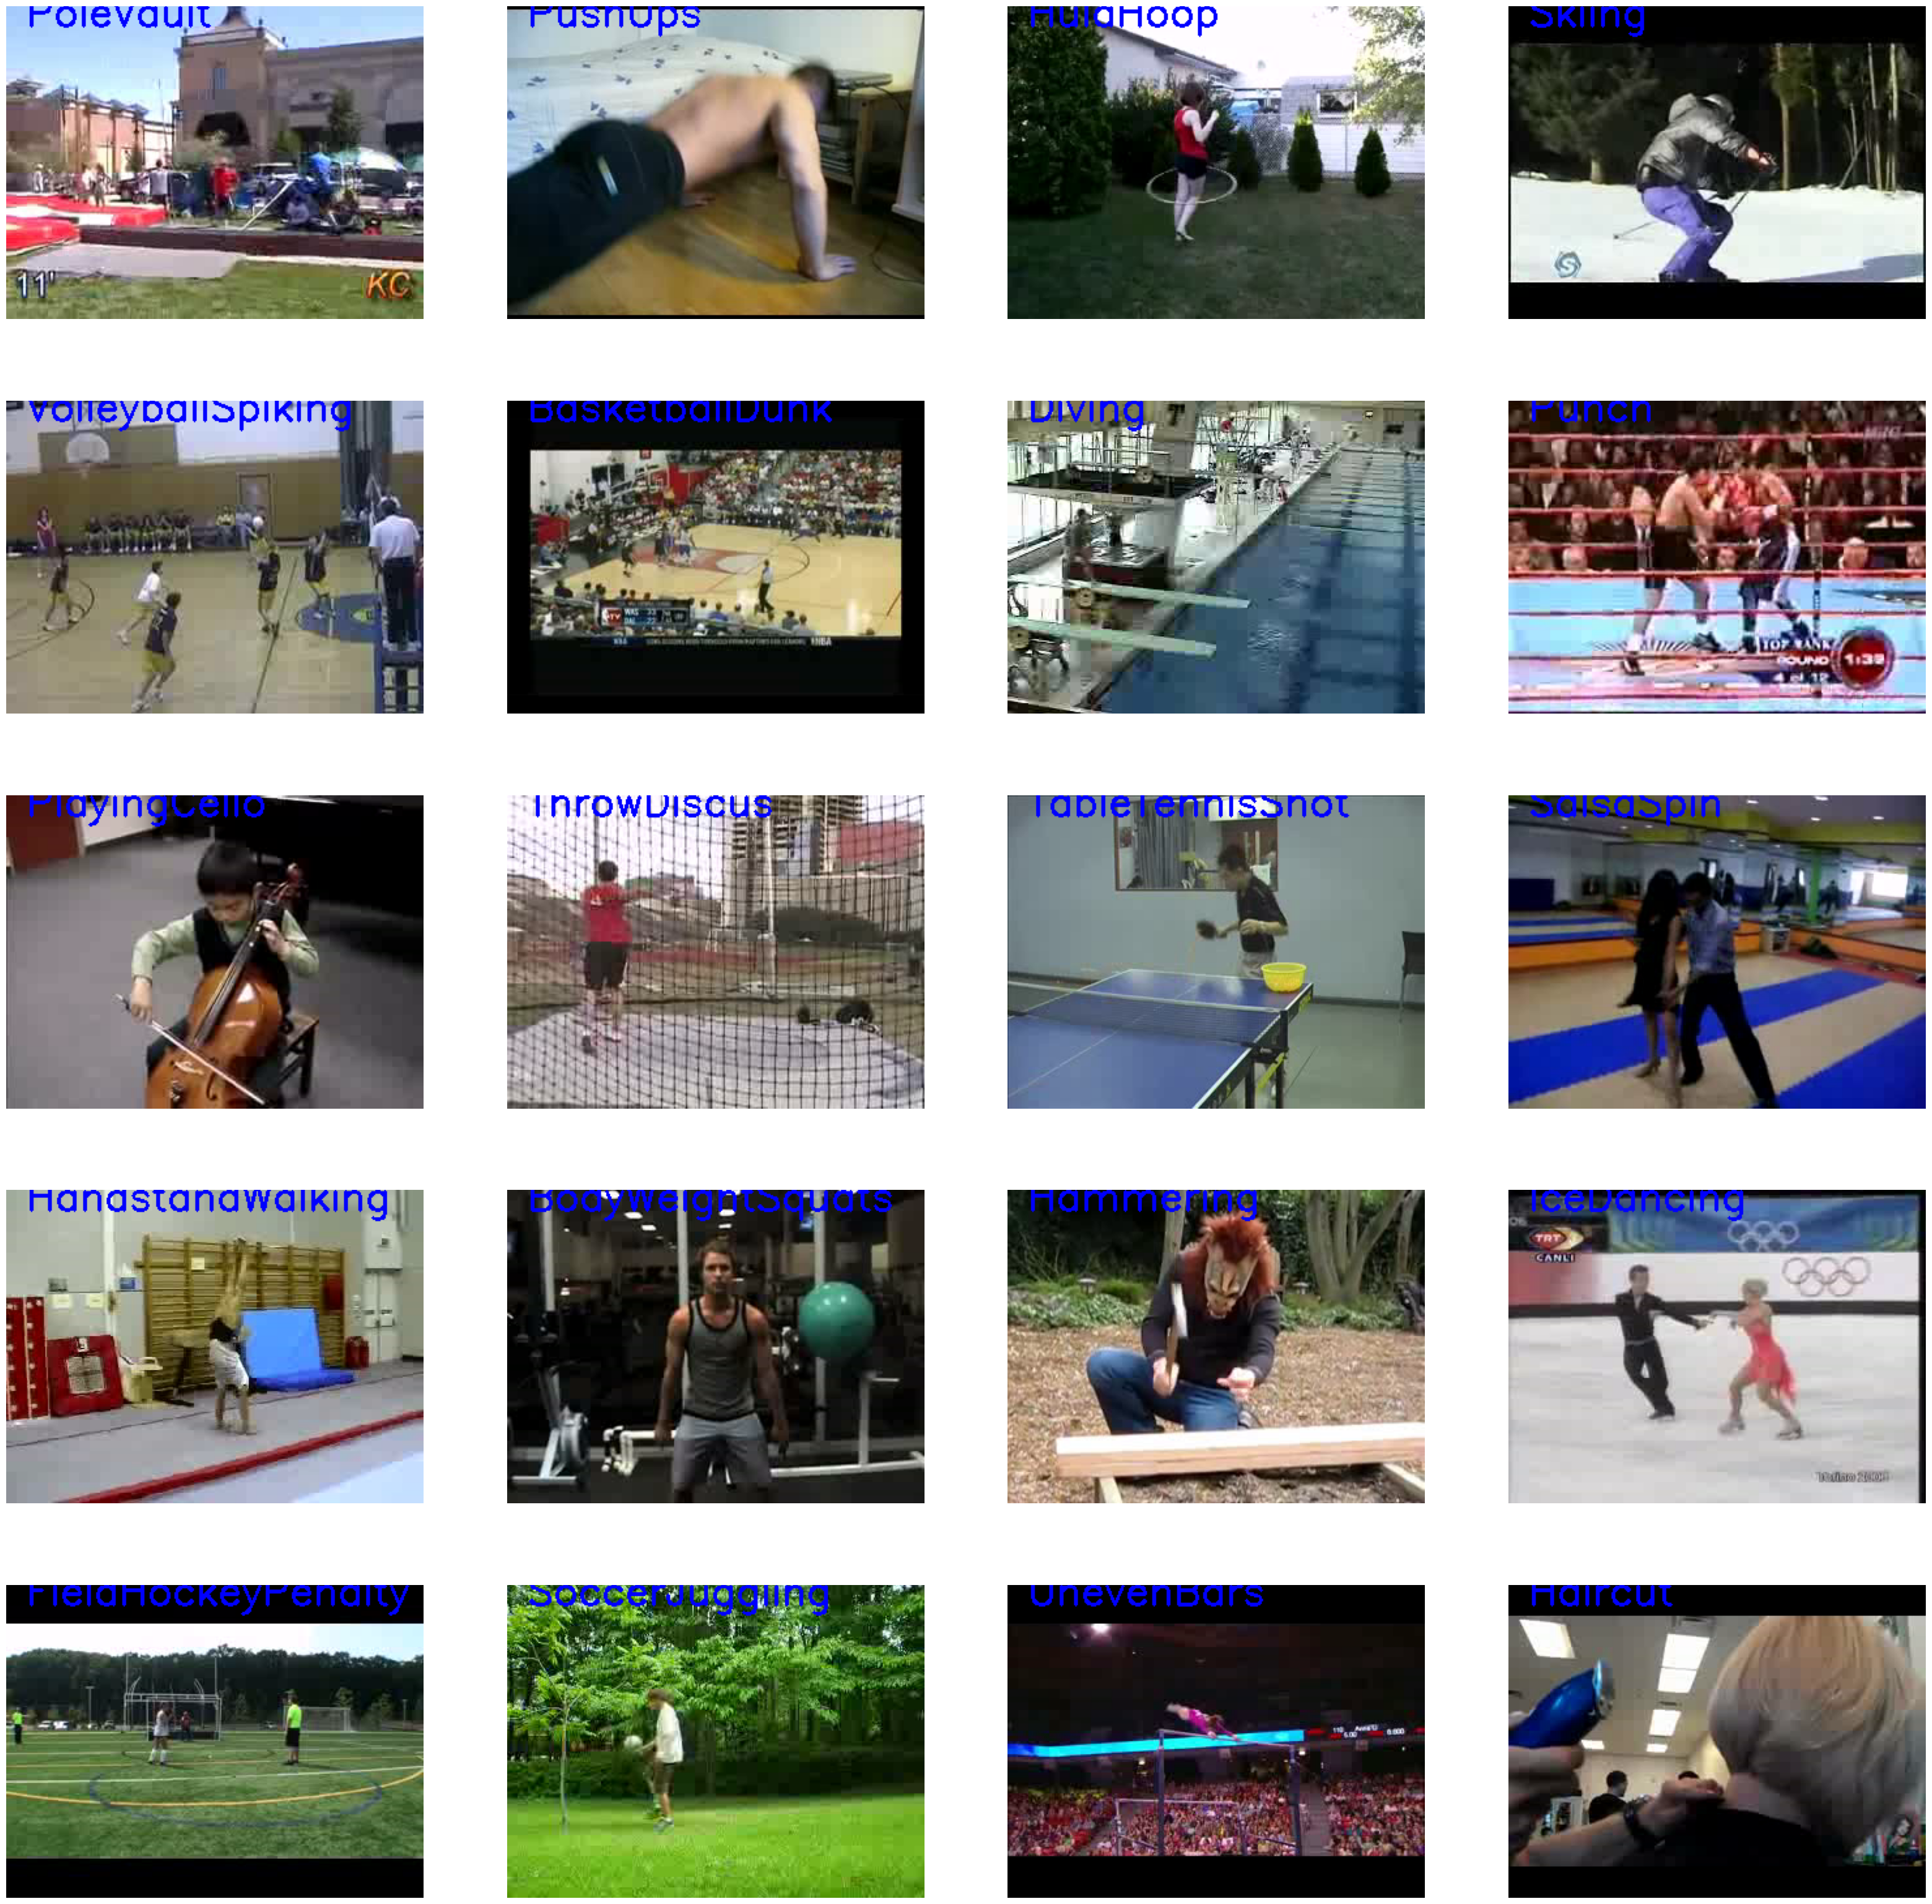

In [4]:
plt.figure(figsize=(40,40))
class_names=os.listdir('UCF-101')
print(f'Total no of class:{len(class_names)}')
rand_range=random.sample(range(len(class_names)),20)#taking random 20 classes
for count,index in enumerate(rand_range,1):
  # print(f'{count}/  /{index}')
  select_class_name=class_names[index]
  video_file_list=os.listdir(f'UCF-101/{select_class_name}')
  video_file_name=random.choice(video_file_list)
  video_reader=cv2.VideoCapture(f'UCF-101/{select_class_name}/{video_file_name}')
  dummy,bgr_frame=video_reader.read()
  video_reader.release()
  rgb_frame=cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame,select_class_name,(15,15),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
  plt.subplot(5,4,count);plt.imshow(rgb_frame);plt.axis('off')

**DATA-PREPROCESSING**

In [5]:
#getting random target sample
num_of_class=10
random_class=random.sample(class_names,num_of_class)
len(random_class)

10

In [6]:
#setting parameters
height,width=64,64
seq_len=20
dataset_dir='UCF-101'
target_class=random_class
print(target_class)

['Skijet', 'WallPushups', 'BreastStroke', 'SkateBoarding', 'SumoWrestling', 'Mixing', 'CliffDiving', 'BoxingSpeedBag', 'PlayingDaf', 'YoYo']


Creating function to extract,resize and normalize

In [7]:
def frame_extraction(path):
  frame_list=[]
  cap=cv2.VideoCapture(path)
  frame_count=int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frame_window=max(int(frame_count/seq_len),1)
  for counter in range(seq_len):
    cap.set(cv2.CAP_PROP_FRAME_COUNT,counter*skip_frame_window)
    success,frame=cap.read()
    if not success:
      break
    resize_img=cv2.resize(frame,(height,width))
    normalize_img=resize_img/255
    frame_list.append(normalize_img)
  cap.release()
  return frame_list  

In [8]:
def create_dataset():
  features=[]
  labels=[]
  video_path=[]
  for index,name in enumerate(target_class):
    print(f'Extracting data of class:{name}')
    file_list=os.listdir(os.path.join(dataset_dir,name))
    for file_name in file_list:
      path=os.path.join(dataset_dir,name,file_name)
      frames=frame_extraction(path)
      if(len(frames)==seq_len):
        features.append(frames)
        labels.append(index)
        video_path.append(path)
  features=np.asarray(features)
  labels=np.array(labels)
  return features,labels,video_path

In [9]:
#Extractng dataset depend on target class
features,labels,video_path=create_dataset()
one_hot_encoded_label=to_categorical(labels)

Extracting data of class:Skijet
Extracting data of class:WallPushups
Extracting data of class:BreastStroke
Extracting data of class:SkateBoarding
Extracting data of class:SumoWrestling
Extracting data of class:Mixing
Extracting data of class:CliffDiving
Extracting data of class:BoxingSpeedBag
Extracting data of class:PlayingDaf
Extracting data of class:YoYo


**SPLITING THE DATASET TO TEST 20% AND TRAIN 80%**

In [10]:
feature_train,feature_test,label_train,label_test=train_test_split(features,one_hot_encoded_label,test_size=0.2,shuffle=True,random_state=seed_c)

**IMPLEMENT THE MODEL CONVOLUTIONAL AND LSTM**

In [11]:
model=Sequential()  
##################################
model.add(TimeDistributed(Conv2D(16,(3,3),padding='same',activation='relu',input_shape=(seq_len,height,width,3))))
model.add(TimeDistributed(MaxPooling2D(4,4)))
model.add(TimeDistributed(Dropout(0.2)))

model.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(4,4)))
model.add(TimeDistributed(Dropout(0.2)))

model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.2)))

model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(32))

model.add(Dense(num_of_class,activation='softmax'))

#######################################

model.build(input_shape=(None, seq_len, height, width, 3))
model.summary()
             

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 4, 4, 32)     0

MODEL ARCHITECTURE

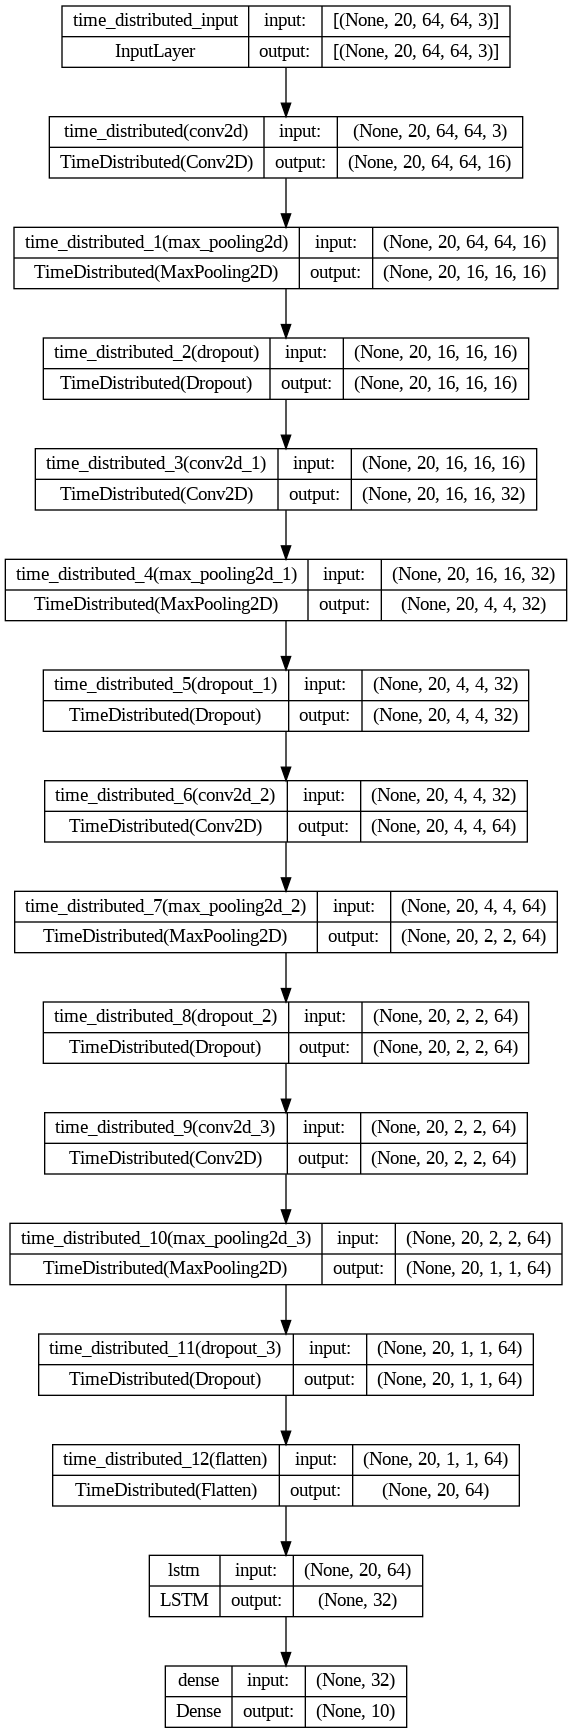

In [12]:
plot_model(model,to_file='model_view.png',show_shapes=True,show_layer_names=True)

**COMPILATION**

In [13]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

**RUNNING THE MODEL**

In [14]:
start_time=time.time()
hist=model.fit(x=feature_train,y=label_train,epochs=25,batch_size=8,shuffle=True,validation_split=0.2)
end_time=time.time()
print(f'Training time is {end_time-start_time} seconds')

Epoch 1/25
101/101 [==============================] - 53s 453ms/step - loss: 2.2824 - accuracy: 0.1372 - val_loss: 2.2782 - val_accuracy: 0.0945
Epoch 2/25
101/101 [==============================] - 45s 445ms/step - loss: 2.0597 - accuracy: 0.2282 - val_loss: 1.7972 - val_accuracy: 0.4030
Epoch 3/25
101/101 [==============================] - 45s 441ms/step - loss: 1.7310 - accuracy: 0.3978 - val_loss: 1.5846 - val_accuracy: 0.4677
Epoch 4/25
101/101 [==============================] - 45s 440ms/step - loss: 1.5680 - accuracy: 0.4551 - val_loss: 1.4824 - val_accuracy: 0.5075
Epoch 5/25
101/101 [==============================] - 45s 442ms/step - loss: 1.3899 - accuracy: 0.5299 - val_loss: 1.5601 - val_accuracy: 0.4876
Epoch 6/25
101/101 [==============================] - 45s 445ms/step - loss: 1.2840 - accuracy: 0.5599 - val_loss: 1.1907 - val_accuracy: 0.5721
Epoch 7/25
101/101 [==============================] - 45s 443ms/step - loss: 1.1190 - accuracy: 0.6197 - val_loss: 1.1060 - val_ac

**EVALUATE THE MODEL**

In [15]:
eval_hist=model.evaluate(feature_test,label_test)

8/8 [==============================] - 6s 831ms/step - loss: 0.5290 - accuracy: 0.8406


**ANALYSIS**

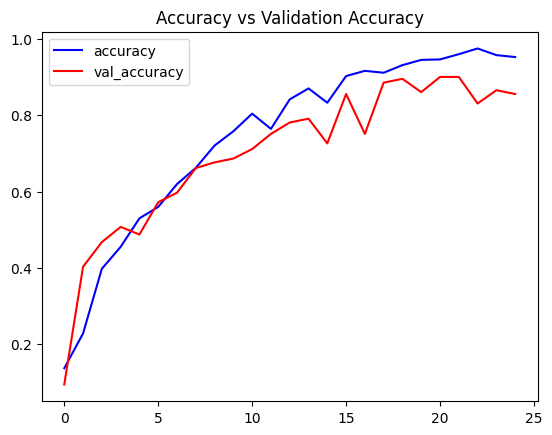

In [16]:
#ACCURACY
x=hist.history['accuracy']
epochs=range(len(x))
plt.plot(epochs,x,'blue',label='accuracy')
plt.plot(epochs,hist.history['val_accuracy'],'red',label='val_accuracy')
plt.title('Accuracy vs Validation Accuracy')
plt.legend()

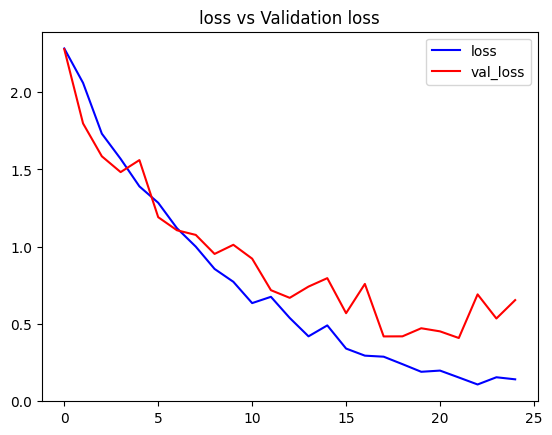

In [17]:
#LOSS
x=hist.history['loss']
epochs=range(len(x))
plt.plot(epochs,x,'blue',label='loss')
plt.plot(epochs,hist.history['val_loss'],'red',label='val_loss')
plt.title('loss vs Validation loss')
plt.legend()

In [18]:
#CONFUSION MATRIX & CLASSIFICATION REPORT
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred=model.predict(feature_test)
y_pred_class=np.argmax(y_pred,axis=1)
y_actual=np.argmax(label_test,axis=1)
cm=confusion_matrix(y_pred_class,y_actual)
print("Confusion matrix")
print(cm)
cr=classification_report(y_pred_class,y_actual)
print("Classification report")
print(cr)

8/8 [==============================] - 5s 483ms/step
Confusion matrix
[[15  0  1  4  1  0  6  0  0  0]
 [ 0 21  0  1  0  0  0  0  0  0]
 [ 0  0 21  1  0  0  0  0  0  0]
 [ 0  1  0 17  0  2  0  0  0  1]
 [ 0  0  0  0 21  1  1  1  0  0]
 [ 1  0  0  1  2 27  1  1  1  0]
 [ 0  0  0  0  0  0 16  2  0  1]
 [ 0  0  0  0  0  0  0 18  0  1]
 [ 0  0  0  1  1  0  1  0 31  0]
 [ 0  1  0  0  0  1  0  2  1 24]]
Classification report
              precision    recall  f1-score   support

           0       0.94      0.56      0.70        27
           1       0.91      0.95      0.93        22
           2       0.95      0.95      0.95        22
           3       0.68      0.81      0.74        21
           4       0.84      0.88      0.86        24
           5       0.87      0.79      0.83        34
           6       0.64      0.84      0.73        19
           7       0.75      0.95      0.84        19
           8       0.94      0.91      0.93        34
           9       0.89      0.83   

TAKE RANDOM 5 SAMPLE AND GENERATE CLASSIFICATION REPORT AND CONFUSION MATRIX

In [19]:
rand_index=np.random.choice(len(feature_test),5,replace=False)
test_sample=feature_test[rand_index]
test_sample_label=label_test[rand_index]
y_pred=model.predict(test_sample)
y_pred_class=np.argmax(y_pred,axis=1)
y_actual=np.argmax(test_sample_label,axis=1)
cm=confusion_matrix(y_pred_class,y_actual)
print("Confusion matrix")
print(cm)
cr=classification_report(y_pred_class,y_actual)
print("Classification report")
print(cr)

1/1 [==============================] - 0s 97ms/step
Confusion matrix
[[1 0 0]
 [0 1 0]
 [0 0 3]]
Classification report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



**SAVE THE MODEL**

In [20]:
model.save('cnn-lstm-1.h5')